Zakarya Ali  
ENSAE - Python pour un data scientist 2A - Xavier Dupré  
[Kaggle Competition - Porto Seguro's Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)  
(**Note**: Notebook tested on both Python 2.7 and 3.6)

# Kaggle Competition : Porto Seguro's safe driver prediction

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Introduction
[Porto Seguro](https://www.portoseguro.com.br/) is a Brazilian insurance company. One of its most important market is the driver insurance. This is a sector where it is quite difficult to assess with certainty which customers will soon file insurance claims. In order to better its insurance claim predictions to better the cost of insurance for every type of drivers, the company launched a Kaggle competition with a 25000$ cash prize.  
In this notebook, we aim at analyzing the dataset delivered by the brazilian company, and implementing a machine learning model to predict the insurance claims.  
**Objective : build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.**

In [1]:
# Python modules used in this notebook
%matplotlib inline
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import psutil
#import os
#import logging
#import sys
#from collections import Counter

# imblearn
# http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html
#from imblearn.over_sampling import SMOTE 
#from imblearn.under_sampling import CondensedNearestNeighbour

#scikit-learn
# http://scikit-learn.org/
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold #cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV #GridSearchCV

# missingno
# https://github.com/ResidentMario/missingno
import missingno 

In [2]:
SAVE_IMAGES = False #If you need to save the generated images
img_dir = "data/img/" #directory to save images
train_dir = "data/train/" #directory where the training file should be
test_dir = "data/test/" #directory where the test file should be

## Dataset Analysis
Let's analyze the training dataset.

In [3]:
### WARNING 
### Get train and test data from kaggle competition data page 
### https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data
train = pd.read_csv(train_dir + "train.csv", sep=",", encoding="utf8", low_memory=False)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
train.drop_duplicates().shape

(595212, 59)

59 columns and almost 600000 observations with no duplicated lines. All the columns represent numeric values.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

### Features
We don't have much information regarding the features. None of them are described. The [competition data presentation](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) only gives a brief introduction.  
- 'id' column : id of the observation
- 'target' column : 1 if the observation concerns an insurance claim 0 if not. This is the column to predict

Features whose names contain :
- 'bin' are binary features 
- 'cat' are categorical features  

On top of it, we assume :
- integer variables are ordinal variable
- float64 variables are numeric one


In [6]:
binary = []
categorical = []
ordinal = []
numeric = []

for c in train.columns:
    if ('bin' in c):
        binary.append(c)
    if 'cat' in c:
        categorical.append(c)
    if ('bin' not in c) & ('cat' not in c) & (c in train.dtypes[train.dtypes=='int64']) & (c not in ['target', 'id']):
        ordinal.append(c)
    if ('bin' not in c) & ('cat' not in c) & (c in train.dtypes[train.dtypes=='float64']):
        numeric.append(c)

In [7]:
#Checking the features categories
print('Binary columns :' + ", ".join(str(x) for x in binary))
print('')
print('Categorical columns :' + ", ".join(str(x) for x in categorical))
print('')
print('Ordinal columns :' + ", ".join(str(x) for x in ordinal))
print('')
print('Numeric columns :' + ", ".join(str(x) for x in numeric))

Binary columns :ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, ps_ind_16_bin, ps_ind_17_bin, ps_ind_18_bin, ps_calc_15_bin, ps_calc_16_bin, ps_calc_17_bin, ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin

Categorical columns :ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_03_cat, ps_car_04_cat, ps_car_05_cat, ps_car_06_cat, ps_car_07_cat, ps_car_08_cat, ps_car_09_cat, ps_car_10_cat, ps_car_11_cat

Ordinal columns :ps_ind_01, ps_ind_03, ps_ind_14, ps_ind_15, ps_car_11, ps_calc_04, ps_calc_05, ps_calc_06, ps_calc_07, ps_calc_08, ps_calc_09, ps_calc_10, ps_calc_11, ps_calc_12, ps_calc_13, ps_calc_14

Numeric columns :ps_reg_01, ps_reg_02, ps_reg_03, ps_car_12, ps_car_13, ps_car_14, ps_car_15, ps_calc_01, ps_calc_02, ps_calc_03


### Missing values
Some observations have missing information.
From the [competition data presentation](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data), we know missing values are noted "-1". We can find them using [missingno](https://github.com/ResidentMario/missingno), a missing data vizualisation module for Python.

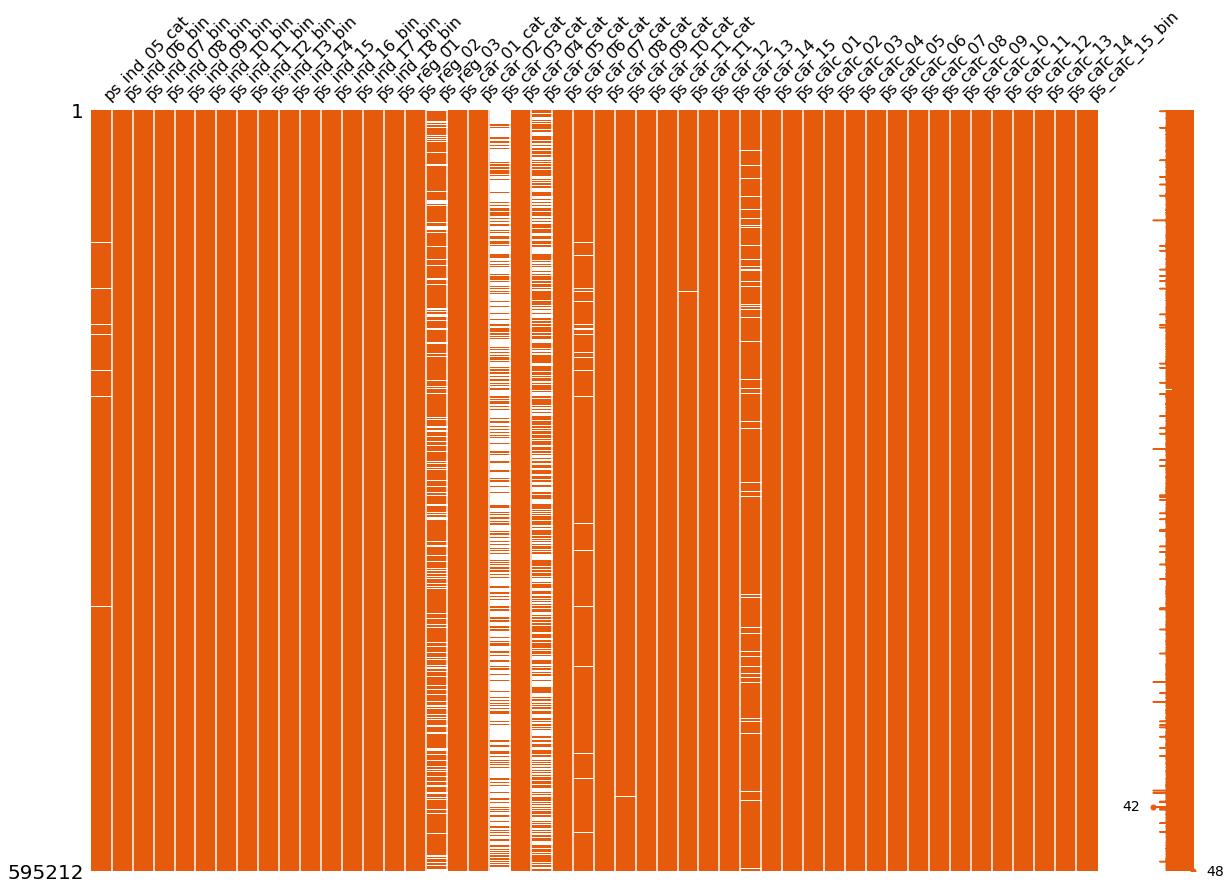

In [8]:
# Missing values by columns
missingno.matrix(df=train.replace(-1, np.NaN).iloc[:,6:54], figsize=(20, 14), color=(0.9, 0.36, 0.047))

As we can see, a few columns have missing values. To be more specific:

In [9]:
incomplete = train.columns[train.eq(-1).any()]

#proportion of missing values for each column
cols_with_na=[]
for c in incomplete:
    missings_values = train[train[c] == -1][c].count()
    missings_perc = missings_values.astype(np.float32)/train.shape[0]*100
    print(str(c) + ' has ' + str(np.round(missings_perc, 3)) + '% missing values')
    if missings_perc<20:
        cols_with_na.append(c)

ps_ind_02_cat has 0.036% missing values
ps_ind_04_cat has 0.014% missing values
ps_ind_05_cat has 0.976% missing values
ps_reg_03 has 18.106% missing values
ps_car_01_cat has 0.018% missing values
ps_car_02_cat has 0.001% missing values
ps_car_03_cat has 69.09% missing values
ps_car_05_cat has 44.783% missing values
ps_car_07_cat has 1.93% missing values
ps_car_09_cat has 0.096% missing values
ps_car_11 has 0.001% missing values
ps_car_12 has 0.0% missing values
ps_car_14 has 7.16% missing values


The two columns **ps_car_03_cat** and **ps_car_05_cat** have missing values rates higher than 40%. We should drop them as they don't give enough information. We'll see how to handle other features with fewer missing values in the dateset treatment section.

### Imbalanced Dataset
By checking the "target" column, we want to see how the dataset is balanced, meaning what is the ratio of insurance claims within the observations. 

In [10]:
target_group = train.groupby(['target']).size()
target_count = target_group.to_frame()
target_count = target_count.reset_index()
target_count = target_count.rename({0: "count"}, axis='columns')
target_count

,target,count
0,0,573518
1,1,21694


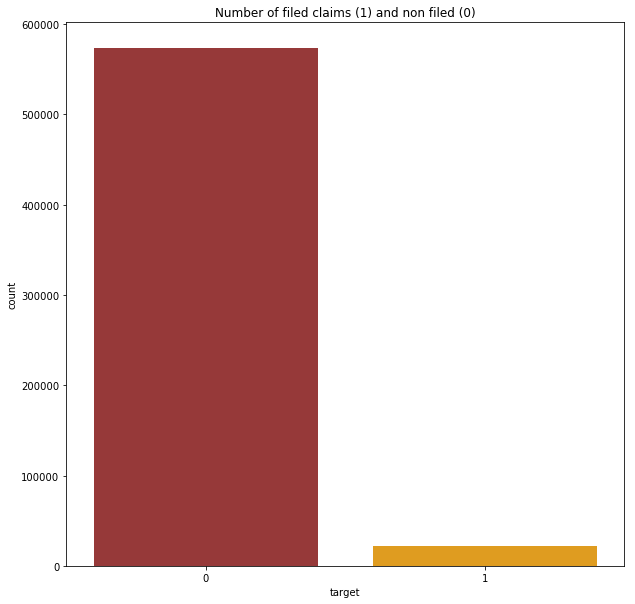

In [11]:
#Target visualization
colors = ['brown','orange']
plt.figure(1, figsize=(10, 10))
ax = sns.barplot(x="target", y="count", data=target_count, ci=None, palette=colors)
plt.title("Number of filed claims (1) and non filed (0)")
if SAVE_IMAGES:
    plt.savefig(img_dir + 'train_target.png', dpi=150)
plt.show()

In [12]:
np.mean(train["target"]) #Rate of 1 in the 'target' column

0.036447517859182946

We only have about 3.6% of filed claims for that policy holder. This is a highly imbalanced dataset. This is not surprising since people don't change file insurance every year. In general, they do so when they acquire a new vehicle. Since the percentage of file claims is very low, we can understand why the company is having a hard time predicting it.

"""
We need to **oversample** values leading to **target=1**  
or **undersample** the other ones  
We choose the first method
""""

### Data correlations
In order to only select relevant variables, we want to check wether or not they are correlated to one another.
The following figures present the correlation matrices of the variables according to their types (numeric, ordinal...) 

In [13]:
def plot_features_correlation(title, dataframe, columns, isSaveImage):
    colormap = plt.cm.Oranges
    plt.figure(figsize=(16,16))
    plt.title(title.title() + ' features correlation', y=1)
    sns.heatmap(dataframe[columns].corr(), cmap=colormap, annot=True)
    if isSaveImage:
        plt.savefig(img_dir + 'train_' + title +'_features_correlation.png', dpi=150)

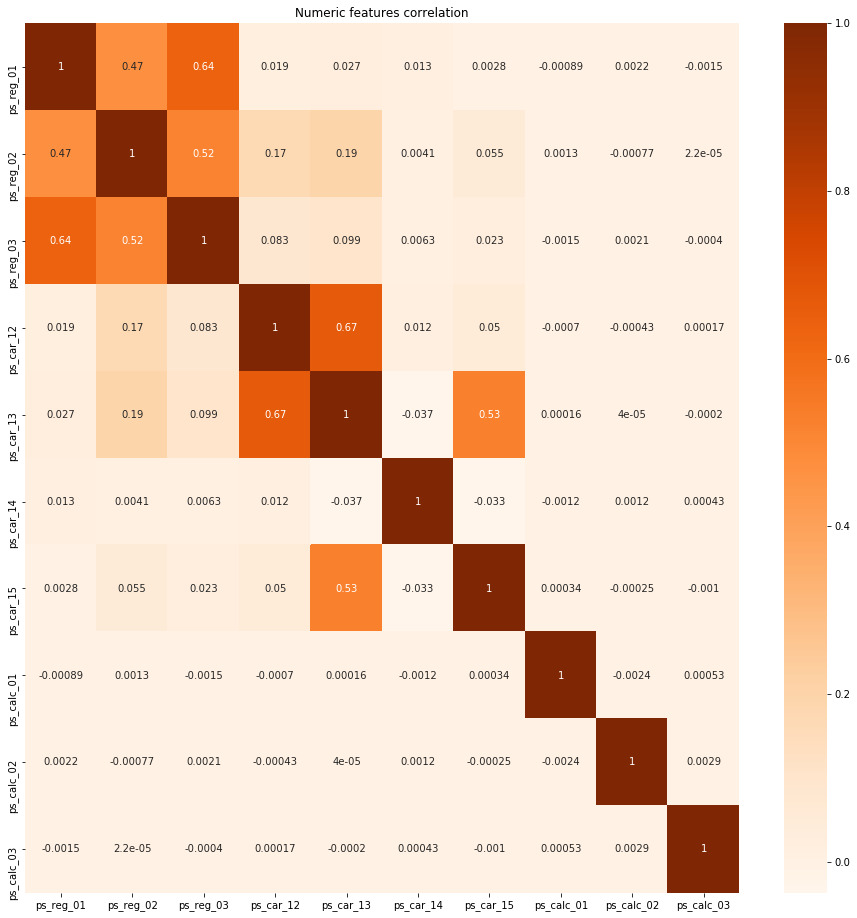

In [14]:
#Numeric features correlation
plot_features_correlation('numeric', train, numeric, SAVE_IMAGES)

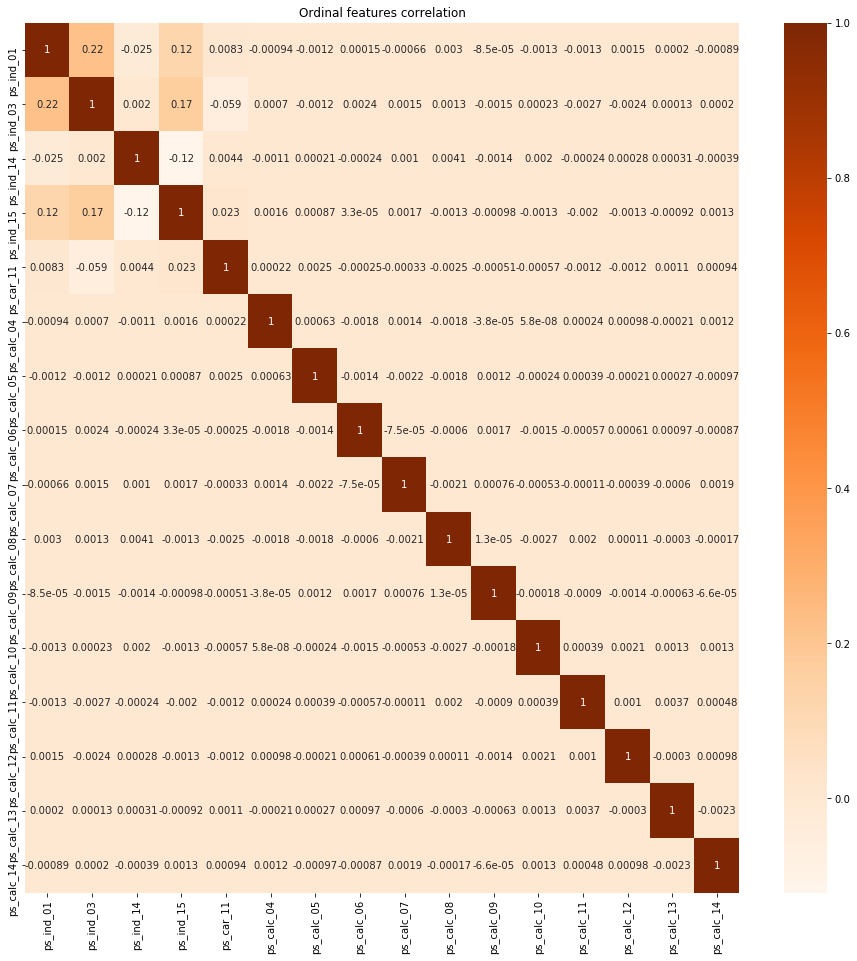

In [15]:
#Ordinal features correlation
plot_features_correlation('ordinal', train, ordinal, SAVE_IMAGES)

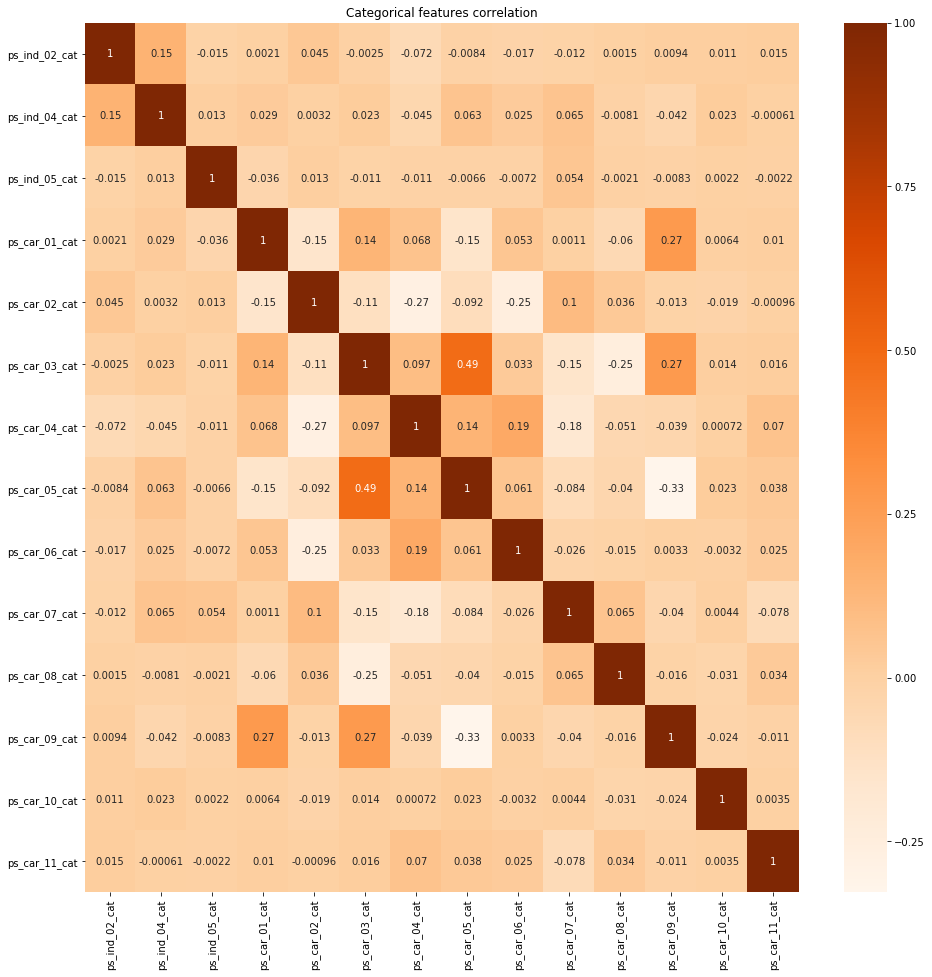

In [16]:
#categorical features correlation
plot_features_correlation('categorical', train, categorical, SAVE_IMAGES)

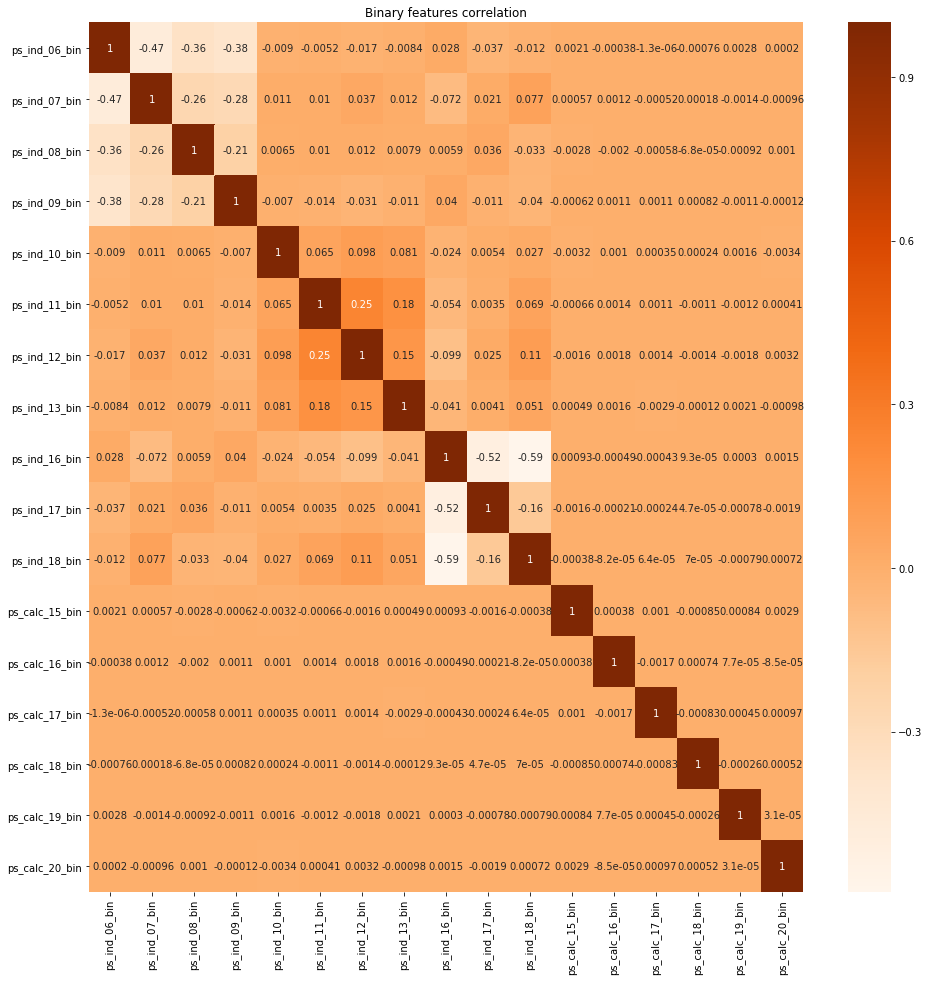

In [17]:
#Binary features correlation
plot_features_correlation('binary', train, binary, SAVE_IMAGES)

From these figures, we can see the most highly correlated varibles are (we retain those for which the coefficient is higher than 0.5) : 
- **ps_reg_01** and **ps_reg_03**
- **ps_reg_02** and **ps_reg_03**
- **ps_car_12** and **ps_car_13**
- **ps_car_13** and **ps_car_15**

#### Binary features
From last plot we notice binary features are note correlated. However, they may have others characteristics which make us think they are not relevant. For example, let's check for each binary features, the 0/1 ratio. 

In [18]:
#We get the ratio of 1s and 0s for all binary features
binary_1 = (np.mean(train[binary]))
binary_0 = (1-binary_1)

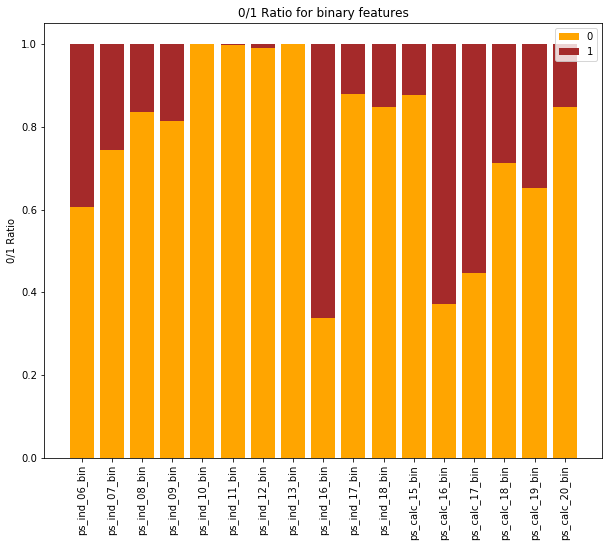

In [19]:
#Plot ratio of all binary features
plt.figure(figsize=(10,8))

x_pos = np.arange(len(binary))
p1 = plt.bar(x_pos, binary_0, color = 'orange',align='center',label='0')
p2 = plt.bar(x_pos, binary_1, color = 'brown', align='center',bottom = binary_0, label='1')
plt.xticks(x_pos, binary)
plt.xticks(rotation='vertical')

plt.ylabel('0/1 Ratio')
plt.title('0/1 Ratio for binary features')
plt.legend((p1[0], p2[0]), ('0', '1'))
if SAVE_IMAGES:
    plt.savefig(img_dir + 'train_binary_features_ratio.png', dpi=150)
plt.show()

From this visualization, we can assure that **ps_ind_10_bin**, **ps_ind_11_bin**, **ps_ind_12_bin** and **ps_ind_13_bin** are not relevant features since these features don't have enough observations with 1s to tell us anything.  
For a more complete approach regarding the most relevant features, we could also have set a random forest to assess the features importance.

#### Categorical variables
We want to see how many distinct elements we have for each categorical variable.  
(**Note**: we don't show ps_car_03_cat and ps_car_05_cat as we saw they have too much missing values)

In [20]:
# Categorical variables : distinct elements
distinct_elements = []
for elem in categorical:
    distinct_elements.append(len(train[elem].unique()))

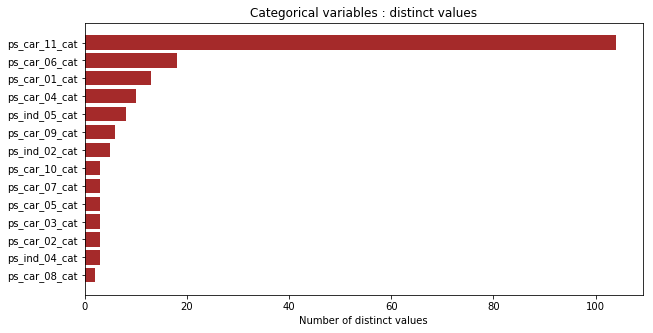

[(u'ps_car_08_cat', 2),
 (u'ps_ind_04_cat', 3),
 (u'ps_car_02_cat', 3),
 (u'ps_car_03_cat', 3),
 (u'ps_car_05_cat', 3),
 (u'ps_car_07_cat', 3),
 (u'ps_car_10_cat', 3),
 (u'ps_ind_02_cat', 5),
 (u'ps_car_09_cat', 6),
 (u'ps_ind_05_cat', 8),
 (u'ps_car_04_cat', 10),
 (u'ps_car_01_cat', 13),
 (u'ps_car_06_cat', 18),
 (u'ps_car_11_cat', 104)]

In [21]:
#We order the elements for the plot
idx= np.argsort(distinct_elements)
bar_cat = np.asarray(categorical)[idx]
bar_dist_elem = np.asarray(distinct_elements)[idx]

# Plot
plt.figure(figsize=(10,5))
#ax.invert_yaxis()  # labels read top-to-bottom
y_pos = np.arange(len(bar_cat))
plt.barh(y_pos, bar_dist_elem, align='center', color='brown')
plt.yticks(y_pos, bar_cat)
plt.xlabel('Number of distinct values')
plt.title('Categorical variables : distinct values')
if SAVE_IMAGES:
    plt.savefig(img_dir + 'train_categorical_features_distinct.png', dpi=150)

plt.show()

list(zip(bar_cat, bar_dist_elem))

**ps_car_11_cat** has the most distinct categories (104) but it is manageable.  
(**Note**: since we did not yet remove missing values for the concerned columns, they count as unique values too)

## Dataset treatment
Here we will develop all the methods necessary for our dataframe to be ready for build a prediction model.
### Dropping irrelevant features
From our analysis, we can safely drop the dataframe following columns :
- ps_ind_10_bin
- ps_ind_11_bin
- ps_ind_12_bin
- ps_ind_13_bin
- ps_car_03_cat
- ps_car_05_cat

In [22]:
# Dropping irrelevant features from the dataframe
columns_to_drop = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_03_cat', 'ps_car_05_cat']
train1 = train
train1.drop(columns_to_drop, inplace=True, axis=1)

In [23]:
#Removing the irrelevant features names from the lists
for elem in columns_to_drop:
    if elem in binary:
        binary.remove(elem)
    elif elem in ordinal:
        ordinal.remove(elem)
    elif elem in categorical:
        categorical.remove(elem)
    elif elem in numeric:
        numeric.remove(elem)

### Treating missing variables
We want to solve the missing data issue by replacing the unknown values by something which would be relevant, or at least easy to use for our prediction model.  

The easiest way to get rid of the missing values is to remove the rows containing them
Let's see how many rows we remove with this method

In [24]:
df_with_missing_values_rows_dropped = train1.replace({-1: np.nan}).dropna().astype(float)

lost_rows = 1 - df_with_missing_values_rows_dropped.shape[0]/train1.shape[0]
print(str(np.round(lost_rows*100, 3)) + '%')

100%


With this method we lose a fourth of the data which is unthinkable
We should try to, if not avoid it, mix it with other methods

Another approach is :
- For **categorical** and **binary** variables, we replace the missing values by the column **mode** (the variable value we encountered the most in the observations)
- For **numeric** and **ordinal** variables, we replace by the missing ones by the column **mean**

In [27]:
# Treating missing variables
def treat_missng_values(df, cols_with_na, categorical, binary, numeric, ordinal):
    for c in cols_with_na:
        if (c in categorical) or (c in binary):
            df.loc[df[c]==-1,c] = df[df[c]!=-1][c].mode()[0] #Replace by the mode (the highest count)
        if (c in numeric) or (c in ordinal):
            df.loc[df[c]==-1,c] = df[df[c]!=-1][c].mean() #Replace by the mean
    return df

train2 = treat_missng_values(train1, cols_with_na, categorical, binary, numeric, ordinal)

In [28]:
# We check there is no missing values anymore
train2.eq(-1).any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat     False
ps_ind_03         False
ps_ind_04_cat     False
ps_ind_05_cat     False
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03         False
ps_car_01_cat     False
ps_car_02_cat     False
ps_car_04_cat     False
ps_car_06_cat     False
ps_car_07_cat     False
ps_car_08_cat     False
ps_car_09_cat     False
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11         False
ps_car_12         False
ps_car_13         False
ps_car_14         False
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03        False
ps_calc_04        False
ps_calc_05        False
ps_calc_06        False
ps_calc_07        False
ps_calc_08        False
ps_calc_09      

### One Hot Encoding

Let's transform each categorical columns into multiple binary columns (1 if the observation belong to the category, 0 otherwise).

In [29]:
train3 = pd.get_dummies(train2, columns=categorical)
train3.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,7,0,2,5,0,1,0,0,0,11,...,0,0,0,0,0,0,0,0,0,0
1,9,0,1,7,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,13,0,5,9,0,0,1,0,0,12,...,0,0,0,0,0,0,0,0,0,0
3,16,0,0,2,1,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,1
4,17,0,0,0,1,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0


We went from 59 columns to 212.

### Feature Scaling

For the model we want to use next, it is necessary to scale our features.

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train3.drop(['id','target'], axis=1))

### Handling data correlation 
**Note** : After running some models I found out it made no difference apply dropping or any other methods on correlated variables. So we will keep them as is.

## Model Building

In [31]:
#Training targets
y_train = train['target'].values.astype(np.int8)

### First approach : PCA
My original approach was to analyze the Dataset and find clusters which would give us more information regarding potential insurance claims.


In [32]:
target_names = np.unique(y_train)
n_components=175

In [33]:
#PCA
pca = PCA(n_components=n_components, svd_solver='full', random_state=2018)
X_pca = pca.fit_transform(X_train)

In [34]:
#Explained Variance
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())
n = 20
print('Individual variance contributions (for the first ' + str(n) + ' components):')
for j in range(n):
    print(pca.explained_variance_ratio_[j])

Explained variance: 0.9840
Individual variance contributions (for the first 20 components):
0.0281384337914
0.016588750749
0.0148826857456
0.0139824044098
0.0127819606696
0.01166337618
0.0111682914016
0.0107850321112
0.010638782699
0.0103941242836
0.0102897053937
0.0100218436673
0.00973832231405
0.00961208432205
0.00939077221998
0.00926353491893
0.00904708156525
0.00895452620872
0.00880625511162
0.00864470702682


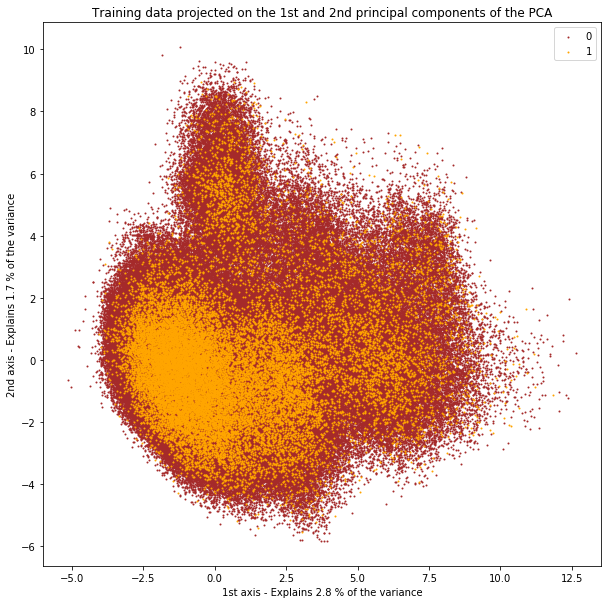

In [35]:
#Plot
plt.figure(1, figsize=(10, 10))
colors = ['brown', 'orange']
for i in target_names:
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=colors[i], s=1, label=i)
plt.legend()
plt.title("Training data projected on the 1st and 2nd principal components of the PCA")
plt.xlabel("1st axis - Explains %.1f %% of the variance" % (pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("2nd axis - Explains %.1f %% of the variance" % (pca.explained_variance_ratio_[1] * 100.0))

if SAVE_IMAGES:
    plt.savefig(img_dir + 'pca.png', dpi=150)
    
plt.show()

As we can see, it is not possible to differentiate 0s and 1s with the 1st and 2nd principal components of a PCA.  
First, the first 20 components only explain less than a fourth of the variance.
Second, 175 components still don't explain 100% of the variance so we better go with the 212 columns we got.

### Second approach : Gradient Boosting
Boosting is an Ensemble technique which aggregates sequantially developped classifiers on a training sample whose individu weights are rectified on the run. The classifiers are weighted according to their performances.

#### Gini coefficient
This competition score is based on the [gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), so we need to evaluate our training set regarding it.

In [36]:
# Gini scoring function from kernel at: 
# https://www.kaggle.com/tezdhar/faster-gini-calculation
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)


gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

#### Dataset split
We will train our models using the k-fold method.
Since we have a highly unbalanced dataset, we want to have the same amount of true value in each of our folds in order to verify our model is not learning nothing in any fold.

In [42]:
folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#### Hyperparameters tuning
To get the best results possible, we want to find the best hyperparameters for our Gradient Boosting classifier. To do so we scikit-learn RandomizedSearchCV,a method which will perform various Gradient Bossting models on our training set from a list of parameters in a random way, for a certain number of iterations.

In [43]:
# Hyperparameters grid for GradientBoosting
params = {
        'min_samples_leaf': [1,5,10],
        'max_depth': [3, 5,7],
        'subsample': [0.6, 0.7,0.8],
        'max_features': [None, 50, 100]
        }

In [44]:
gb_clr = GradientBoostingClassifier(n_estimators=500, learning_rate=0.02)
#gb_clr.get_params().keys()

In [45]:
n_iter = 8
random_search = RandomizedSearchCV(gb_clr, param_distributions=params, n_iter=n_iter, scoring=gini_sklearn, n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=2017)

random_search.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10 
[CV] max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10 
[CV] max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10 
[CV] max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10 
[CV]  max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10, score=0.273446272519, total=143.4min
[CV] max_features=None, subsample=0.7, max_depth=7, min_samples_leaf=10 
[CV]  max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10, score=0.287395122087, total=143.8min
[CV] max_features=None, subsample=0.7, max_depth=7, min_samples_leaf=10 
[CV]  max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10, score=0.287761806122, total=144.9min
[CV] max_features=None, subsample=0.7, max_depth=7, min_samples_leaf=10 
[CV]  max_features=100, subsample=0.8, max_depth=7, min_samples_leaf=10, score=0.269111934105, total=14

In [46]:
print('Best hyperparameters :')
print(random_search.best_params_)

Best hyperparameters :
{'max_features': 50, 'subsample': 0.8, 'max_depth': 7, 'min_samples_leaf': 10}


With this method, the best hyperparameters were (in my case) : 
- max_features=50, 
- subsample=0.8, 
- max_depth=7, 
- min_samples_leaf=10

## Test set and Submission

Now, we want to make prediction on the test set with our best hyperparameters.  
First we will have to treat the dataset the same way we did with our training observations :

In [47]:
#Test dataset treatment
test = pd.read_csv(test_dir + "test.csv", sep=",", encoding="utf8", low_memory=False)
test_ids = test["id"]
test = test.drop(["id"], axis = 1)
test.drop(columns_to_drop, inplace=True, axis=1)
test = treat_missng_values(test, cols_with_na, categorical, binary, numeric, ordinal)
#We have the same categorical variables for both the training and the test sets
test = pd.get_dummies(test, columns=categorical)
X_test = scaler.fit_transform(test)

In [48]:
y_test = grid.best_estimator_.predict_proba(test)

In [49]:
# Submission
results = pd.DataFrame(data={'id':test_ids, 'target':y_test[:,1]})
#results.head()
results.to_csv(path_or_buf="submission.csv", columns=["id", "target"], index=False)

With this method we get a score of 0.270 wich places us in the top 10% leaderboard.

## Conclusion
Even if we get a high ranking result, there is still a lot of ways to improve our predictions.
Here are some ways to better the results :
1. With Gradient boosting, like Random Forest, we can rank the features in terms of importance. A good approach would be to select the n mort important features and build a new model from them.
2. We use stratified folds since the set is highly unbalanced. But we could also apply oversampling as a way to train our algorithm and detect more insurance filing. 
3. Optimize the hyper parameters search using GridSearchCV on all parameters would be better but way more time consuming.
4. Bayesian optimization is a much better approach to optimize the parameters search as it will.
5. My first approach was to use neural networks, I wish to pursue further this approach (see this [Notebook](kaggle-porto_seguro_nn_v01.ipynb) to know more about this approach).

# Sources

- Data exploration :
    - https://www.kaggle.com/tilii7/dimensionality-reduction-pca-tsne
    - https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
    - https://www.kaggle.com/bertcarremans/data-preparation-exploration
- Handling imbalanced Dataset :
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    - http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/ml_b_imbalanced.html#mlbimbalancedrst
- Deep Learning with Pytorch :
    - http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/210_Convolution_MNIST.html#convolutionmnistrst
- Gini coefficient :
    - https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation
- Gradient Boosting Finetuning :
    - https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/